# Import libarires and load data

In [1]:
# Standard library
import warnings
import random
import time

# Data handling
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Statistical functions
from scipy.stats import norm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    root_mean_squared_error,
    accuracy_score,
    r2_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler

# XGBoost
from xgboost import XGBRegressor

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import weight_norm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
def set_seed(seed):
    """
    Set random seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(101)

In [4]:
df = pd.read_csv(
    "../Processed_data/Main_df.csv",
    #index_col=0,           # <— first column becomes the index
    parse_dates=True       # auto–parse that index into datetime
)
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.tail()

,Date,BTC,BTC_Volume,BTC_count,reward,days_since_halving,ETH,ETH_Volume,ETH_count,BCH,...,M2,MSTR,MSTR30,MSTR_Holdings,NVDIA,SP500,day_change,week_change,month_change,6month_change
6309,2025-07-17,119289.842192,7.236384e+10,1.989281e+07,3.125,453.0,3476.784398,4.753285e+10,1.206906e+08,500.064196,...,22020.8,451.339996,9450.0,601550.0,173.000000,6297.359863,0.0,NaN,NaN,NaN
6310,2025-07-18,118003.224496,7.794580e+10,1.989334e+07,3.125,454.0,3549.016245,5.919847e+10,1.207105e+08,514.428382,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,0.0,NaN,NaN,NaN
6311,2025-07-19,117939.978739,4.756456e+10,1.989535e+07,3.125,455.0,3595.273669,2.603172e+10,1.207110e+08,513.423144,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,0.0,NaN,NaN,NaN
6312,2025-07-20,117300.785740,5.751545e+10,1.989606e+07,3.125,456.0,3759.471442,4.460045e+10,1.206943e+08,547.876271,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,1.0,NaN,NaN,NaN
6313,2025-07-21,117439.535800,6.982009e+10,1.989339e+07,3.125,457.0,3763.371253,4.261147e+10,1.206961e+08,523.554650,...,22020.8,426.279999,15670.0,607770.0,171.380005,6305.600098,NaN,NaN,NaN,NaN


In [5]:
df1=df[['BTC', 'BTC_Volume', 'BTC_count', 'reward','days_since_halving', 'ETH', 'BCH', 'DXY', 'fed_rate', 'gold', 'inflation', 'M2',
       'MSTR', 'MSTR30', 'MSTR_Holdings', 'NVDIA', 'SP500']]

df1 = df1.dropna(subset=["days_since_halving"])

df1['log_BTC'] = np.log(df1['BTC'])
df1['log_ETH'] = np.log(df1['ETH'])
df1['log_BCH'] = np.log(df1['BCH'])
df1['log_gold'] = np.log(df1['gold'])
df1['log_MSTR']= np.log(df1['MSTR'])
df1['log_NVDIA'] = np.log(df1['NVDIA'])
df1['log_SP500'] = np.log(df1['SP500'])
df1['log_BTC_Volume'] = np.log(df1['BTC_Volume']+1)
df1['log_BTC_count'] = np.log(df1['BTC_count'])

# df1["DXY"]= df1["DXY"]/10
# df1["fed_rate"] = df1["fed_rate"]*10
# df1["inflation"] = df1["inflation"]*7
# df1["M2"] = df1["M2"]/1000
# df1["MSTR30"] = df1["MSTR30"]/300

df1=df1.drop(columns=['BTC', 'ETH', 'BCH', 'gold', 'MSTR', 'NVDIA', 'SP500','BTC_Volume', 'BTC_count'])
df1.tail()

,reward,days_since_halving,DXY,fed_rate,inflation,M2,MSTR30,MSTR_Holdings,log_BTC,log_ETH,log_BCH,log_gold,log_MSTR,log_NVDIA,log_SP500,log_BTC_Volume,log_BTC_count
6309,3.125,453.0,121.0417,4.33,2.672683,22020.8,9450.0,601550.0,11.689311,8.153863,6.214736,5.728768,6.112221,5.153292,8.747886,25.004973,16.805869
6310,3.125,454.0,120.7674,4.33,2.672683,22020.8,9450.0,601550.0,11.678467,8.174426,6.243056,5.731365,6.047892,5.149875,8.747795,25.079280,16.805896
6311,3.125,455.0,120.7674,4.33,2.672683,22020.8,9450.0,601550.0,11.677931,8.187375,6.241100,5.731365,6.047892,5.149875,8.747795,24.585354,16.805997
6312,3.125,456.0,120.7674,4.33,2.672683,22020.8,9450.0,601550.0,11.672497,8.232034,6.306049,5.731365,6.047892,5.149875,8.747795,24.775319,16.806032
6313,3.125,457.0,120.7674,4.33,2.672683,22020.8,15670.0,607770.0,11.673679,8.233070,6.260641,5.746618,6.055096,5.143883,8.749193,24.969188,16.805898


In [6]:
df1["days_total"]=range(len(df1))

df1['day^2']=df1['days_total']**2
df1['day^3']=df1['days_total']**3
df1['day^4']=df1['days_total']**4

df1["Sin1"]= np.sin(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos1"]= np.cos(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin2"]= np.sin(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos2"]= np.cos(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin3"]= np.sin(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos3"]= np.cos(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin4"]= np.sin(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos4"]= np.cos(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin5"]= np.sin(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos5"]= np.cos(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin6"]= np.sin(6 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos6"]= np.cos(6 * 2 * np.pi * df1["days_since_halving"] / 1439)

df1['SinY1'] = np.sin(2 * np.pi * df1['days_total'] / 365.25)
df1['CosY1'] = np.cos(2 * np.pi * df1['days_total'] / 365.25)
df1['SinY2'] = np.sin(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['CosY2'] = np.cos(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['SinY3'] = np.sin(3 * 2 * np.pi * df1['days_total'] / 365.25) 
df1['CosY3'] = np.cos(3 * 2 * np.pi * df1['days_total'] / 365.25)

df1['day reward'] = df1['days_total'] * df1['reward']
df1['day^2 reward']= df1['day^2'] * df1['reward']

df1['Sin1 reward'] = df1['Sin1'] * df1['reward']
df1['Cos1 reward'] = df1['Cos1'] * df1['reward']
df1['Sin2 reward'] = df1['Sin2'] * df1['reward']
df1['Cos2 reward'] = df1['Cos2'] * df1['reward']
df1['Sin3 reward'] = df1['Sin3'] * df1['reward']
df1['Cos3 reward'] = df1['Cos3'] * df1['reward']
df1['Sin4 reward'] = df1['Sin4'] * df1['reward']
df1['Cos4 reward'] = df1['Cos4'] * df1['reward']

In [7]:
other_features = ['log_BTC_Volume', 'log_BTC_count', 'reward',  'DXY',
       'fed_rate', 'inflation', 'M2', 'MSTR30', 'MSTR_Holdings',
        'log_gold', 'log_MSTR', 'log_NVDIA', 'log_SP500']  #'log_ETH', 'log_BCH',
ts_features = ["days_total","day^2","Sin1 reward","Cos1 reward", "Sin2","Cos2"]

df2=df1[other_features + ts_features+['log_BTC']]

scaler = StandardScaler()
df2[other_features]=scaler.fit_transform(df2[other_features])

df2.tail()

C:\Users\deepe\AppData\Local\Temp\ipykernel_51100\320967390.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[other_features]=scaler.fit_transform(df2[other_features])


,log_BTC_Volume,log_BTC_count,reward,DXY,fed_rate,inflation,M2,MSTR30,MSTR_Holdings,log_gold,log_MSTR,log_NVDIA,log_SP500,days_total,day^2,Sin1 reward,Cos1 reward,Sin2,Cos2,log_BTC
6309,0.792569,1.058534,-1.270893,0.894814,1.488299,0.012947,1.457238,0.450547,4.426298,2.986989,3.190675,1.915415,1.971546,5299,28079401,2.869525,-1.237517,-0.727263,-0.686359,11.689311
6310,0.804935,1.058690,-1.270893,0.866420,1.488299,0.012947,1.457238,0.450547,4.426298,2.997458,3.120190,1.913565,1.971312,5300,28090000,2.864095,-1.250035,-0.733229,-0.679982,11.678467
6311,0.722741,1.059274,-1.270893,0.866420,1.488299,0.012947,1.457238,0.450547,4.426298,2.997458,3.120190,1.913565,1.971312,5301,28100601,2.858609,-1.262528,-0.739139,-0.673553,11.677931
6312,0.754353,1.059479,-1.270893,0.866420,1.488299,0.012947,1.457238,0.450547,4.426298,2.997458,3.120190,1.913565,1.971312,5302,28111204,2.853069,-1.274998,-0.744992,-0.667073,11.672497
6313,0.786614,1.058702,-1.270893,0.866420,1.488299,0.012947,1.457238,0.931738,4.477997,3.058928,3.128084,1.910320,1.974936,5303,28121809,2.847475,-1.287443,-0.750789,-0.660542,11.673679


# Network Architecture

In [9]:
import torch
import torch.nn as nn

class ResidualLSTM(nn.Module):
    """
    Joint exogenous‐LSTM + AR(1) model.  
    Inputs:
      x_feat  of shape (B, K, f)     – your ff features over the last K days  
      x_resid of shape (B, K, 1)     – the residual history over the last K days  
    Output:
      resid_pred of shape (B, 1)     – forecasted residual Days ahead
    """
    def __init__(self, feat_dim, hidden_size=50, num_layers=1, p_dropout=0.1,init_alpha = 0.15):
        super().__init__()
        # Exogenous LSTM branch
        self.lstm = nn.LSTM(
            input_size  = feat_dim,
            hidden_size = hidden_size,
            num_layers  = num_layers,
            batch_first = True,
            dropout     = p_dropout if num_layers>1 else 0
        )
        # Head to map LSTM hidden→residual
        self.exog_head = nn.Linear(hidden_size, 1)
        
        self.ar_weight = nn.Parameter(torch.zeros(1))    
        raw_init = torch.log(torch.tensor(init_alpha) / (1 - init_alpha))
        self.alpha_raw = nn.Parameter(raw_init)

    def forward(self, x_feat, x_resid):
        """
        x_feat:  (B, K, f)
        x_resid: (B, K, 1)
        returns: (B, 1)
        """
        _, (h_n, _) = self.lstm(x_feat)       
        exog_out    = self.exog_head(h_n[-1]) # take last layer’s hidden state → (B, 1)

        B, K, _ = x_resid.shape
        alpha = torch.sigmoid(self.alpha_raw)
        ex_weights = alpha**(torch.arange(K-1, -1, -1, device=x_resid.device))
        ex_weights = ex_weights / ex_weights.sum()
        resid_seq = x_resid.squeeze(-1)                # (B, K)
        resid_avg = (resid_seq * ex_weights).sum(dim=1, keepdim=True)
        #last_resid = x_resid[:, -1, :]        # (B, 1)
        ar_out     = resid_avg * (1+self.ar_weight) #+ self.ar_bias

        return exog_out + ar_out              # (B, 1)


#  Stimulation of model

## Predict 14 days ahead

Predicting directional change 14-days in the future, use Trend+Seasonality + ResidualLSTM
Processing time index 5289 / 5290  (avg 0.046 s/iter)
Best baseline accuracy is: 53.581%

Trend+Seasonality:
  Observed accuracy = 51.806%  (1606/3100)
  z-score = -1.981
  Approx. one-sided p-value = 0.97619
Confusion Matrix (rows=true, cols=pred):
[[ 538  901]
 [ 593 1068]]

Trend+Seasonality + Net:
  Observed accuracy = 55.548%  (1722/3100)
  z-score = 2.197
  Approx. one-sided p-value = 0.01402
Confusion Matrix (rows=true, cols=pred):
[[723 716]
 [662 999]]


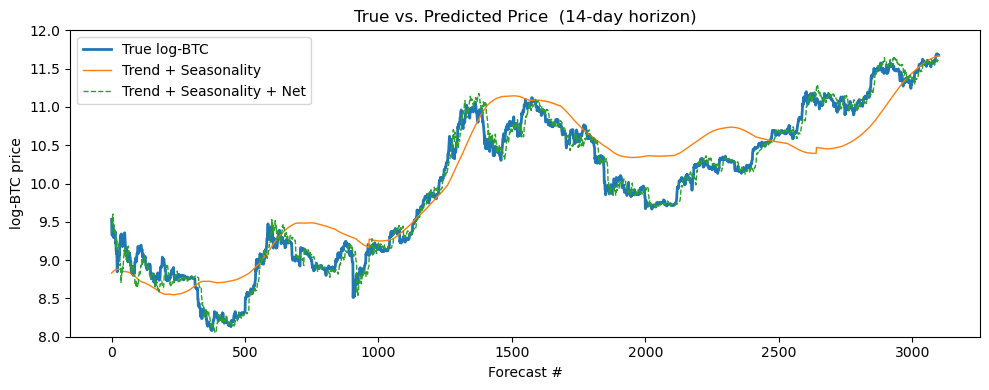

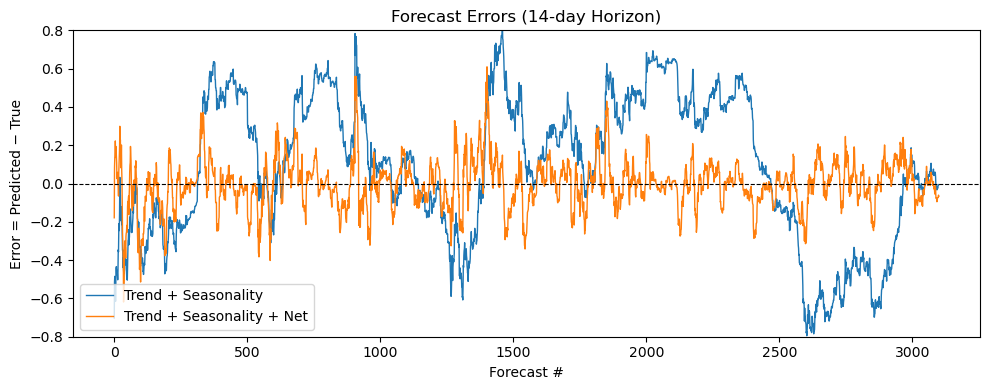

Classification report for Trend+Seasonality+Net:
              precision    recall  f1-score   support

        Down       0.52      0.50      0.51      1439
          Up       0.58      0.60      0.59      1661

    accuracy                           0.56      3100
   macro avg       0.55      0.55      0.55      3100
weighted avg       0.55      0.56      0.55      3100



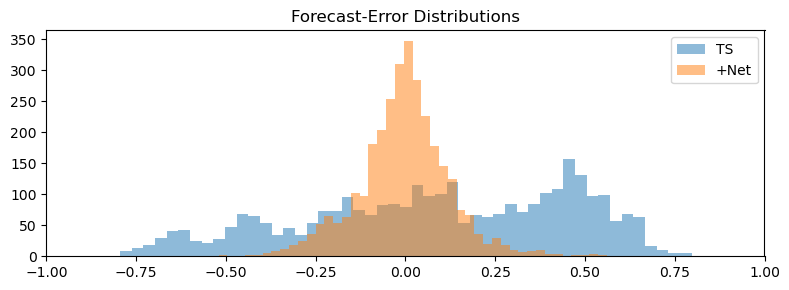

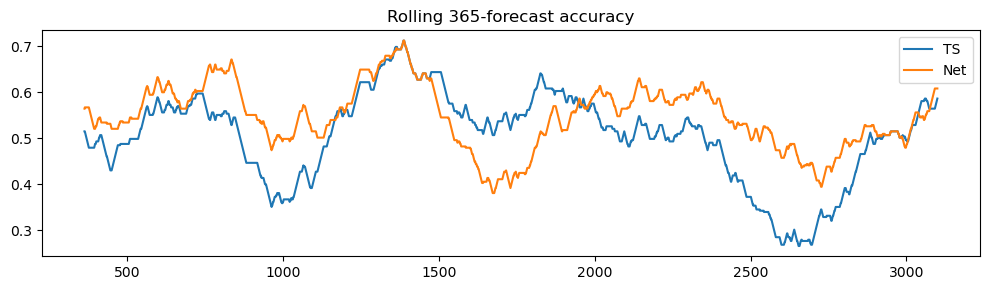

In [12]:
set_seed(101)

Days = 14
print(f"Predicting directional change {Days}-days in the future, use Trend+Seasonality + ResidualLSTM")

data = df2.copy()

ff=['M2']

seq_len = 7                      # how many past days to feed into the LSTM
mlp_batch_size = 32
mlp_lr         = 1e-5
mlp_wd         = 1e-3   # L2 regularization
mlp_epochs     = 3
net  = ResidualLSTM(feat_dim=len(ff), hidden_size=25).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=mlp_lr, weight_decay=mlp_wd)
loss_fn   = nn.MSELoss()


dir_true      = []
dir_pred_ts = []
dir_pred_net  = []

y_t_list = []
y_td_true_list      = []
y_td_hat_ts_list  = []
y_td_hat_net_list   = []

min_train = 365 * 6
n = len(data)
start_time = time.time()

ii=0

for t in range(min_train, n - Days):
    ii+=1
    elapsed = time.time() - start_time
    avg_per_iter = elapsed / ii
    print(
        f"Processing time index {t} / {n-Days}  "
        f"(avg {avg_per_iter:.3f} s/iter)",
        end="\r"
    )

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[ts_features]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Trend+Seasonality log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][ts_features]
    X_td  = data.iloc[[t+Days]][ts_features]
    y_t_hat_ts  = lr.predict(X_t)[0]
    y_td_hat_ts = lr.predict(X_td)[0]

    # 3) Train net on residuals, 
    resid = y_train - lr.predict(X_train)
    resid_target = pd.Series(resid).shift(-Days)
    #    Drop the last 'Days' rows (they have NaN targets)
    if t == min_train:
        X_win = train[ff].iloc[: -Days].values            # shape (N, f)
        R_win = resid.iloc[: -Days].values                # shape (N,)
        y_win = resid_target.iloc[: -Days].values         # shape (N,)
    else:
        X_win = train[ff].iloc[-Days-60 : -Days].values    # shape (D+60, f)
        R_win = resid.iloc[-Days-60 : -Days].values        # shape (D+60,)
        y_win = resid_target.iloc[-Days-60 : -Days].values # shape (D+60,)

    # build sliding windows of length `seq_len`
    T = X_win.shape[0]
    seq_feats, seq_resids, targets = [], [], []
    for i in range(T - seq_len + 1):
        seq_feats.append(  X_win[i : i+seq_len] )            # (seq_len, f)
        seq_resids.append( R_win[i : i+seq_len].reshape(-1,1) )  # (seq_len, 1)
        targets.append( y_win[i + seq_len - 1] )

    X_seq   = torch.tensor(np.stack(seq_feats),  dtype=torch.float32, device=device)  # (B, seq_len, f)
    R_seq   = torch.tensor(np.stack(seq_resids), dtype=torch.float32, device=device)  # (B, seq_len, 1)
    y_seq   = torch.tensor(targets,              dtype=torch.float32, device=device)  # (B,)
    
    loader = DataLoader(
        TensorDataset(X_seq, R_seq, y_seq),
        batch_size=mlp_batch_size,
        shuffle=True
    )  
    
    net.train()
    for _ in range(mlp_epochs):
        for xb_f, xb_r, yb in loader:
            optimizer.zero_grad()
            preds = net(xb_f, xb_r)
            loss  = loss_fn(preds.squeeze(-1), yb)
            loss.backward()
            optimizer.step()
    feat_window  = data[ff].iloc[t-seq_len+1 : t+1].values    # (seq_len, feat_dim)
    resid_window = np.array(resid.iloc[t-seq_len+1 : t+1]).reshape(seq_len, 1)
    x_feat_eval  = torch.tensor(feat_window[np.newaxis, ...], dtype=torch.float32, device=device)   # (1, seq_len, feat_dim)
    x_resid_eval = torch.tensor(resid_window[np.newaxis, ...], dtype=torch.float32, device=device) # (1, seq_len, 1)
    net.eval()
    with torch.no_grad():
        resid_pred = net(x_feat_eval, x_resid_eval).item()

    y_td_hat_net = y_td_hat_ts + resid_pred
    
    # 6) Record
    y_t=data.iloc[t]["log_BTC"]
    y_td=data.iloc[t+Days]["log_BTC"]

    dir_true.append(1 if y_td  > y_t else 0)
    dir_pred_ts.append(1 if y_td_hat_ts  > y_t_hat_ts  else 0)
    dir_pred_net.append( 1 if y_td_hat_net > y_t else 0)

    # --- store for later plotting ---
    y_t_list.append(y_t)
    y_td_true_list.append(y_td)
    y_td_hat_ts_list.append(y_td_hat_ts)
    y_td_hat_net_list.append(y_td_hat_net)


always1_acc = np.mean(dir_true)
always0_acc = 1 - always1_acc
yt = np.array(dir_true)
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
# print("Baselines:")
# print(f"  Always predict UP (1):        {always1_acc:.3%}")
# print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
# print(f"  Predict same as past:    {lag_acc:.3%}")
# print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

baselines = [always1_acc, always0_acc, lag_acc, opp_lag_acc]
p0 = max(baselines)
print(f"Best baseline accuracy is: {p0:.3%}")

N = len(dir_true)

models = {
    "Trend+Seasonality":           dir_pred_ts,
    "Trend+Seasonality + Net":     dir_pred_net
}

# 4) Compute z and approximate p-value
for name, preds in models.items():
    # count corrects
    preds = np.array(preds)
    true  = np.array(dir_true)
    k     = np.sum(preds == true)
    acc   = k / N
    cm= confusion_matrix(true, preds)

    # Normal approx
    mu    = N * p0
    sigma = np.sqrt(N * p0 * (1 - p0))
    z     = (k - mu) / sigma
    pval  = norm.sf(z)   # 1 - Phi(z)

    print(f"\n{name}:")
    print(f"  Observed accuracy = {acc:.3%}  ({k}/{N})")
    print(f"  z-score = {z:.3f}")
    print(f"  Approx. one-sided p-value = {pval:.5f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)

x = np.arange(len(y_td_true_list))

plt.figure(figsize=(10,4))
plt.plot(x, y_td_true_list,      label="True log-BTC",       linewidth=2)
plt.plot(x, y_td_hat_ts_list,  label="Trend + Seasonality",       linewidth=1)
plt.plot(x, y_td_hat_net_list,   label=f"Trend + Seasonality + Net", linewidth=1, linestyle="--")
plt.ylim(8, 12)
plt.xlabel("Forecast #")
plt.ylabel("log-BTC price")
plt.title(f"True vs. Predicted Price  ({Days}-day horizon)")
plt.legend()
plt.tight_layout()
plt.show()

# build the x-axis
x = np.arange(len(y_td_true_list))

# compute the three error series
errors_ts = np.array(y_td_hat_ts_list)  - np.array(y_td_true_list)
errors_net  = np.array(y_td_hat_net_list) - np.array(y_td_true_list)

plt.figure(figsize=(10,4))
plt.plot(x, errors_ts, label="Trend + Seasonality", linewidth=1)
plt.plot(x, errors_net,  label="Trend + Seasonality + Net", linewidth=1)

plt.ylim(-0.8, 0.8)
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)

plt.xlabel("Forecast #")
plt.ylabel("Error = Predicted − True")
plt.title(f"Forecast Errors ({Days}-day Horizon)")
plt.legend()
plt.tight_layout()
plt.show()

print("Classification report for Trend+Seasonality+Net:")
print(classification_report(dir_true, dir_pred_net, target_names=["Down","Up"]))

plt.figure(figsize=(8,3))
plt.hist(errors_ts, bins=50, alpha=0.5, label="TS")
plt.hist(errors_net,  bins=50, alpha=0.5, label="+Net")
plt.xlim(-1,1)
plt.legend()
plt.title("Forecast‐Error Distributions")
plt.tight_layout()
plt.show()

df_acc = pd.DataFrame({
    "TS": np.array(dir_pred_ts)==np.array(dir_true),
    "Net": np.array(dir_pred_net)==np.array(dir_true),
})
rolling = df_acc.rolling(365).mean()

plt.figure(figsize=(10,3))
for col in rolling.columns:
    plt.plot(rolling[col], label=col)
plt.legend()
plt.title("Rolling 365-forecast accuracy")
plt.tight_layout()
plt.show()


## Predict 30 days ahead

Predicting directional change 30-days in the future, use Trend+Seasonality + ResidualLSTM
Processing time index 5273 / 5274  (avg 0.047 s/iter)
Best baseline accuracy is: 53.956%

Trend+Seasonality:
  Observed accuracy = 53.470%  (1649/3084)
  z-score = -0.542
  Approx. one-sided p-value = 0.70606
Confusion Matrix (rows=true, cols=pred):
[[ 539  881]
 [ 554 1110]]

Trend+Seasonality + Net:
  Observed accuracy = 58.625%  (1808/3084)
  z-score = 5.202
  Approx. one-sided p-value = 0.00000
Confusion Matrix (rows=true, cols=pred):
[[849 571]
 [705 959]]


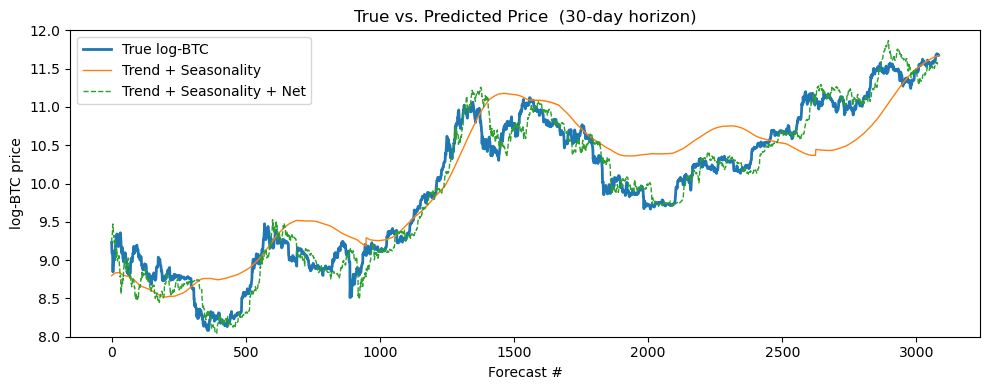

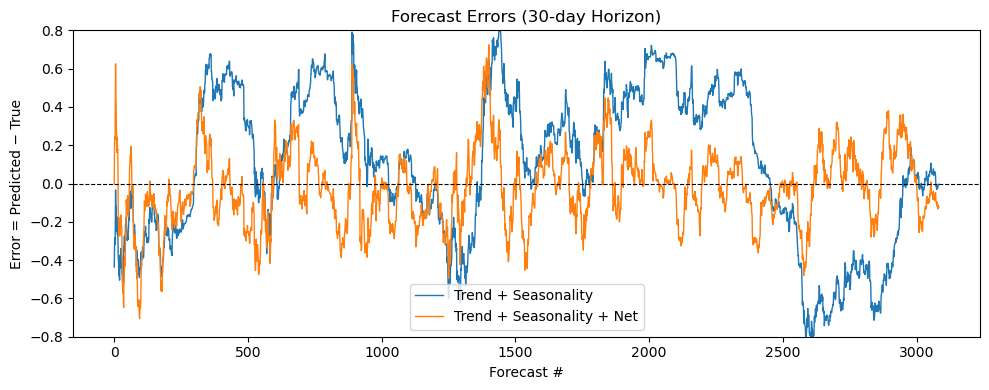

Classification report for Trend+Seasonality+Net:
              precision    recall  f1-score   support

        Down       0.55      0.60      0.57      1420
          Up       0.63      0.58      0.60      1664

    accuracy                           0.59      3084
   macro avg       0.59      0.59      0.59      3084
weighted avg       0.59      0.59      0.59      3084



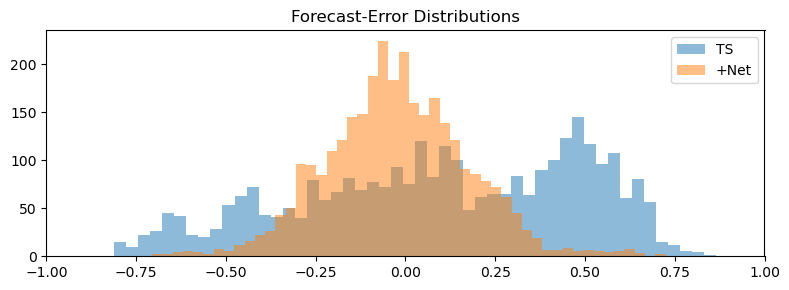

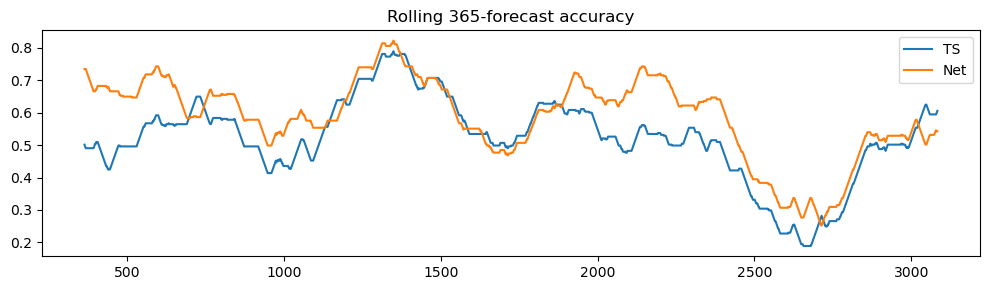

In [14]:
set_seed(101)

Days = 30
print(f"Predicting directional change {Days}-days in the future, use Trend+Seasonality + ResidualLSTM")

data = df2.copy()

ff=['M2','DXY','MSTR30']

seq_len = 7                      # how many past days to feed into the LSTM
mlp_batch_size = 32
mlp_lr         = 1e-5
mlp_wd         = 1e-4   # L2 regularization
mlp_epochs     = 3
net  = ResidualLSTM(feat_dim=len(ff), hidden_size=25).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=mlp_lr, weight_decay=mlp_wd)
loss_fn   = nn.MSELoss()


dir_true      = []
dir_pred_ts = []
dir_pred_net  = []

y_t_list = []
y_td_true_list      = []
y_td_hat_ts_list  = []
y_td_hat_net_list   = []

min_train = 365 * 6
n = len(data)
start_time = time.time()

ii=0

for t in range(min_train, n - Days):
    ii+=1
    elapsed = time.time() - start_time
    avg_per_iter = elapsed / ii
    print(
        f"Processing time index {t} / {n-Days}  "
        f"(avg {avg_per_iter:.3f} s/iter)",
        end="\r"
    )

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[ts_features]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Trend+Seasonality log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][ts_features]
    X_td  = data.iloc[[t+Days]][ts_features]
    y_t_hat_ts  = lr.predict(X_t)[0]
    y_td_hat_ts = lr.predict(X_td)[0]

    # 3) Train net on residuals, 
    resid = y_train - lr.predict(X_train)
    resid_target = pd.Series(resid).shift(-Days)
    #    Drop the last 'Days' rows (they have NaN targets)
    if t == min_train:
        X_win = train[ff].iloc[: -Days].values            # shape (N, f)
        R_win = resid.iloc[: -Days].values                # shape (N,)
        y_win = resid_target.iloc[: -Days].values         # shape (N,)
    else:
        X_win = train[ff].iloc[-3*Days : -Days].values    # shape (3D, f)
        R_win = resid.iloc[-3*Days : -Days].values        # shape (3D,)
        y_win = resid_target.iloc[-3*Days : -Days].values # shape (3D,)

    # build sliding windows of length `seq_len`
    T = X_win.shape[0]
    seq_feats, seq_resids, targets = [], [], []
    for i in range(T - seq_len + 1):
        seq_feats.append(  X_win[i : i+seq_len] )            # (seq_len, f)
        seq_resids.append( R_win[i : i+seq_len].reshape(-1,1) )  # (seq_len, 1)
        targets.append( y_win[i + seq_len - 1] )

    X_seq   = torch.tensor(np.stack(seq_feats),  dtype=torch.float32, device=device)  # (B, seq_len, f)
    R_seq   = torch.tensor(np.stack(seq_resids), dtype=torch.float32, device=device)  # (B, seq_len, 1)
    y_seq   = torch.tensor(targets,              dtype=torch.float32, device=device)  # (B,)
    
    loader = DataLoader(
        TensorDataset(X_seq, R_seq, y_seq),
        batch_size=mlp_batch_size,
        shuffle=True
    )  
    
    net.train()
    for _ in range(mlp_epochs):
        for xb_f, xb_r, yb in loader:
            optimizer.zero_grad()
            preds = net(xb_f, xb_r)
            loss  = loss_fn(preds.squeeze(-1), yb)
            loss.backward()
            optimizer.step()
    feat_window  = data[ff].iloc[t-seq_len+1 : t+1].values    # (seq_len, feat_dim)
    resid_window = np.array(resid.iloc[t-seq_len+1 : t+1]).reshape(seq_len, 1)
    x_feat_eval  = torch.tensor(feat_window[np.newaxis, ...], dtype=torch.float32, device=device)   # (1, seq_len, feat_dim)
    x_resid_eval = torch.tensor(resid_window[np.newaxis, ...], dtype=torch.float32, device=device) # (1, seq_len, 1)
    net.eval()
    with torch.no_grad():
        resid_pred = net(x_feat_eval, x_resid_eval).item()

    y_td_hat_net = y_td_hat_ts + resid_pred
    
    # 6) Record
    y_t=data.iloc[t]["log_BTC"]
    y_td=data.iloc[t+Days]["log_BTC"]

    dir_true.append(1 if y_td  > y_t else 0)
    dir_pred_ts.append(1 if y_td_hat_ts  > y_t_hat_ts  else 0)
    dir_pred_net.append( 1 if y_td_hat_net > y_t else 0)

    # --- store for later plotting ---
    y_t_list.append(y_t)
    y_td_true_list.append(y_td)
    y_td_hat_ts_list.append(y_td_hat_ts)
    y_td_hat_net_list.append(y_td_hat_net)

always1_acc = np.mean(dir_true)
always0_acc = 1 - always1_acc
yt = np.array(dir_true)
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
# print("Baselines:")
# print(f"  Always predict UP (1):        {always1_acc:.3%}")
# print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
# print(f"  Predict same as past:    {lag_acc:.3%}")
# print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

baselines = [always1_acc, always0_acc, lag_acc, opp_lag_acc]
p0 = max(baselines)
print(f"Best baseline accuracy is: {p0:.3%}")

N = len(dir_true)

models = {
    "Trend+Seasonality":           dir_pred_ts,
    "Trend+Seasonality + Net":     dir_pred_net
}

# 4) Compute z and approximate p-value
for name, preds in models.items():
    # count corrects
    preds = np.array(preds)
    true  = np.array(dir_true)
    k     = np.sum(preds == true)
    acc   = k / N
    cm= confusion_matrix(true, preds)

    # Normal approx
    mu    = N * p0
    sigma = np.sqrt(N * p0 * (1 - p0))
    z     = (k - mu) / sigma
    pval  = norm.sf(z)   # 1 - Phi(z)

    print(f"\n{name}:")
    print(f"  Observed accuracy = {acc:.3%}  ({k}/{N})")
    print(f"  z-score = {z:.3f}")
    print(f"  Approx. one-sided p-value = {pval:.5f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)

x = np.arange(len(y_td_true_list))

plt.figure(figsize=(10,4))
plt.plot(x, y_td_true_list,      label="True log-BTC",       linewidth=2)
plt.plot(x, y_td_hat_ts_list,  label="Trend + Seasonality",       linewidth=1)
plt.plot(x, y_td_hat_net_list,   label=f"Trend + Seasonality + Net", linewidth=1, linestyle="--")
plt.ylim(8, 12)
plt.xlabel("Forecast #")
plt.ylabel("log-BTC price")
plt.title(f"True vs. Predicted Price  ({Days}-day horizon)")
plt.legend()
plt.tight_layout()
plt.show()

# build the x-axis
x = np.arange(len(y_td_true_list))

# compute the three error series
errors_ts = np.array(y_td_hat_ts_list)  - np.array(y_td_true_list)
errors_net  = np.array(y_td_hat_net_list) - np.array(y_td_true_list)

plt.figure(figsize=(10,4))
plt.plot(x, errors_ts, label="Trend + Seasonality", linewidth=1)
plt.plot(x, errors_net,  label="Trend + Seasonality + Net", linewidth=1)

plt.ylim(-0.8, 0.8)
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)

plt.xlabel("Forecast #")
plt.ylabel("Error = Predicted − True")
plt.title(f"Forecast Errors ({Days}-day Horizon)")
plt.legend()
plt.tight_layout()
plt.show()

print("Classification report for Trend+Seasonality+Net:")
print(classification_report(dir_true, dir_pred_net, target_names=["Down","Up"]))

plt.figure(figsize=(8,3))
plt.hist(errors_ts, bins=50, alpha=0.5, label="TS")
plt.hist(errors_net,  bins=50, alpha=0.5, label="+Net")
plt.xlim(-1,1)
plt.legend()
plt.title("Forecast‐Error Distributions")
plt.tight_layout()
plt.show()

df_acc = pd.DataFrame({
    "TS": np.array(dir_pred_ts)==np.array(dir_true),
    "Net": np.array(dir_pred_net)==np.array(dir_true),
})
rolling = df_acc.rolling(365).mean()

plt.figure(figsize=(10,3))
for col in rolling.columns:
    plt.plot(rolling[col], label=col)
plt.legend()
plt.title("Rolling 365-forecast accuracy")
plt.tight_layout()
plt.show()


## Predict 60 days ahead

Predicting directional change 60-days in the future, use Trend + Seasonality + LSTM
Processing time index 5243 / 5244  (avg 0.046 s/iter)
Best baseline accuracy is: 55.311%

Trend+Seasonality:
  Observed accuracy = 60.904%  (1860/3054)
  z-score = 6.217
  Approx. one-sided p-value = 0.00000
Confusion Matrix (rows=true, cols=pred):
[[ 636  751]
 [ 443 1224]]

Trend+Seasonality + Net:
  Observed accuracy = 62.541%  (1910/3054)
  z-score = 8.037
  Approx. one-sided p-value = 0.00000
Confusion Matrix (rows=true, cols=pred):
[[975 412]
 [732 935]]


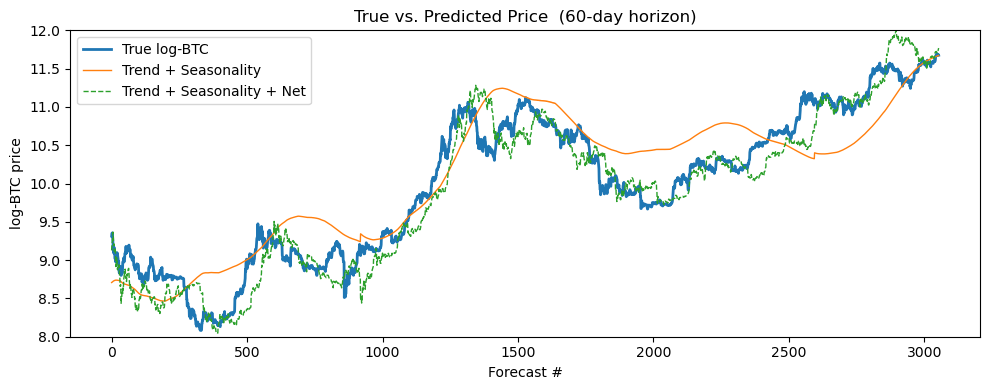

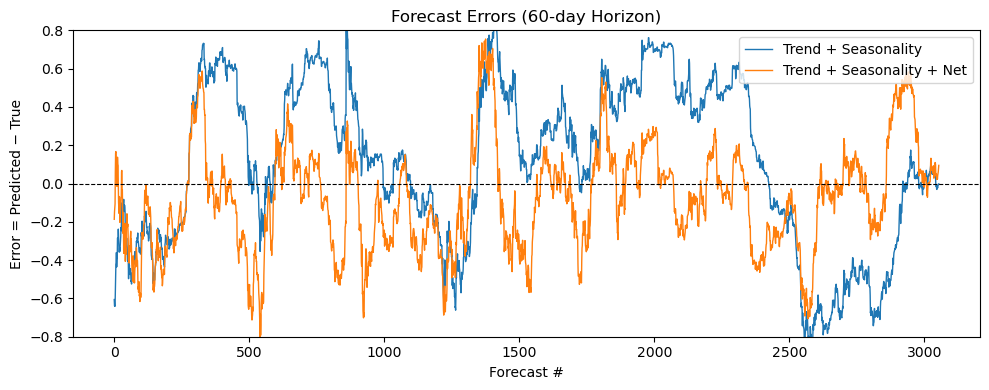

Classification report for Trend+Seasonality+Net:
              precision    recall  f1-score   support

        Down       0.57      0.70      0.63      1387
          Up       0.69      0.56      0.62      1667

    accuracy                           0.63      3054
   macro avg       0.63      0.63      0.63      3054
weighted avg       0.64      0.63      0.62      3054



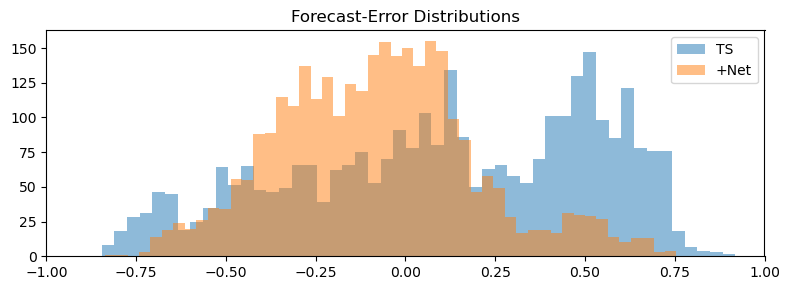

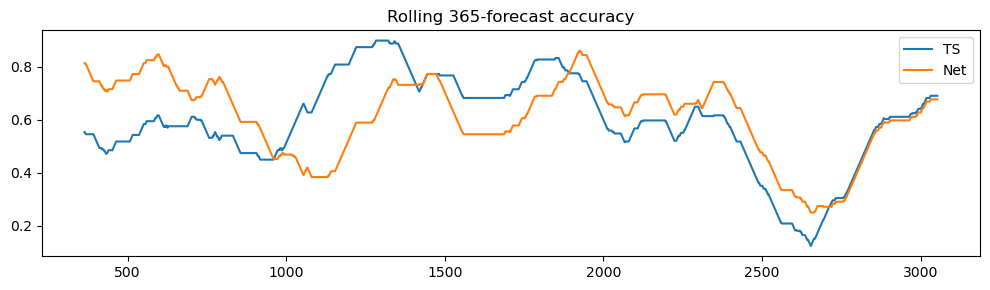

In [32]:
set_seed(101)

p=1
Days = 60
print(f"Predicting directional change {Days}-days in the future, use Trend + Seasonality + LSTM")

data = df2.copy()

ff=['M2','MSTR30','DXY']#['fed_rate', ,'log_MSTR','log_NVDIA']#,,

seq_len = 30                      # how many past days to feed into the LSTM
mlp_batch_size = 32
mlp_lr         = 1e-5
mlp_wd         = 1e-2   # L2 regularization
mlp_epochs     = 1
net  = ResidualLSTM(feat_dim=len(ff), hidden_size=25).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=mlp_lr, weight_decay=mlp_wd)
loss_fn   = nn.MSELoss()


dir_true      = []
dir_pred_ts = []
dir_pred_net  = []

y_t_list = []
y_td_true_list      = []
y_td_hat_ts_list  = []
y_td_hat_net_list   = []

min_train = 365 * 6
n = len(data)
start_time = time.time()

ii=0

for t in range(min_train, n - Days):
    ii+=1
    elapsed = time.time() - start_time
    avg_per_iter = elapsed / ii
    print(
        f"Processing time index {t} / {n-Days}  "
        f"(avg {avg_per_iter:.3f} s/iter)",
        end="\r"
    )

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[ts_features]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Trend+Seasonality log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][ts_features]
    X_td  = data.iloc[[t+Days]][ts_features]
    y_t_hat_ts  = lr.predict(X_t)[0]
    y_td_hat_ts = lr.predict(X_td)[0]

    # 3) Train net on residuals, 
    resid = y_train - lr.predict(X_train)
    resid_target = pd.Series(resid).shift(-Days)
    #    Drop the last 'Days' rows (they have NaN targets)
    if t == min_train:
        X_win = train[ff].iloc[: -Days].values            # shape (N, f)
        R_win = resid.iloc[: -Days].values                # shape (N,)
        y_win = resid_target.iloc[: -Days].values         # shape (N,)
    else:
        X_win = train[ff].iloc[-Days-80 : -Days].values    # shape (3D, f)
        R_win = resid.iloc[-Days-80 : -Days].values        # shape (3D,)
        y_win = resid_target.iloc[-Days-80 : -Days].values # shape (3D,)

    # build sliding windows of length `seq_len`
    T = X_win.shape[0]
    seq_feats, seq_resids, targets = [], [], []
    for i in range(T - seq_len + 1):
        seq_feats.append(  X_win[i : i+seq_len] )            # (seq_len, f)
        seq_resids.append( R_win[i : i+seq_len].reshape(-1,1) )  # (seq_len, 1)
        targets.append( y_win[i + seq_len - 1] )

    X_seq   = torch.tensor(np.stack(seq_feats),  dtype=torch.float32, device=device)  # (B, seq_len, f)
    R_seq   = torch.tensor(np.stack(seq_resids), dtype=torch.float32, device=device)  # (B, seq_len, 1)
    y_seq   = torch.tensor(targets,              dtype=torch.float32, device=device)  # (B,)
    
    loader = DataLoader(
        TensorDataset(X_seq, R_seq, y_seq),
        batch_size=mlp_batch_size,
        shuffle=True
    )  
    
    net.train()
    for _ in range(mlp_epochs):
        for xb_f, xb_r, yb in loader:
            optimizer.zero_grad()
            preds = net(xb_f, xb_r)
            loss  = loss_fn(preds.squeeze(-1), yb)
            loss.backward()
            optimizer.step()
    feat_window  = data[ff].iloc[t-seq_len+1 : t+1].values    # (seq_len, feat_dim)
    resid_window = np.array(resid.iloc[t-seq_len+1 : t+1]).reshape(seq_len, 1)
    x_feat_eval  = torch.tensor(feat_window[np.newaxis, ...], dtype=torch.float32, device=device)   # (1, seq_len, feat_dim)
    x_resid_eval = torch.tensor(resid_window[np.newaxis, ...], dtype=torch.float32, device=device) # (1, seq_len, 1)
    net.eval()
    with torch.no_grad():
        resid_pred = net(x_feat_eval, x_resid_eval).item()

    y_td_hat_net = y_td_hat_ts + resid_pred

    
    # 6) Record
    y_t=data.iloc[t]["log_BTC"]
    y_td=data.iloc[t+Days]["log_BTC"]

    dir_true.append(1 if y_td  > y_t else 0)
    dir_pred_ts.append(1 if y_td_hat_ts  > y_t_hat_ts  else 0)
    dir_pred_net.append( 1 if y_td_hat_net > y_t else 0)

    # --- store for later plotting ---
    y_t_list.append(y_t)
    y_td_true_list.append(y_td)
    y_td_hat_ts_list.append(y_td_hat_ts)
    y_td_hat_net_list.append(y_td_hat_net)

always1_acc = np.mean(dir_true)
always0_acc = 1 - always1_acc
yt = np.array(dir_true)
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
# print("Baselines:")
# print(f"  Always predict UP (1):        {always1_acc:.3%}")
# print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
# print(f"  Predict same as past:    {lag_acc:.3%}")
# print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

baselines = [always1_acc, always0_acc, lag_acc, opp_lag_acc]
p0 = max(baselines)
print(f"Best baseline accuracy is: {p0:.3%}")

N = len(dir_true)

models = {
    "Trend+Seasonality":           dir_pred_ts,
    "Trend+Seasonality + Net":     dir_pred_net
}

# 4) Compute z and approximate p-value
for name, preds in models.items():
    # count corrects
    preds = np.array(preds)
    true  = np.array(dir_true)
    k     = np.sum(preds == true)
    acc   = k / N
    cm= confusion_matrix(true, preds)

    # Normal approx
    mu    = N * p0
    sigma = np.sqrt(N * p0 * (1 - p0))
    z     = (k - mu) / sigma
    pval  = norm.sf(z)   # 1 - Phi(z)

    print(f"\n{name}:")
    print(f"  Observed accuracy = {acc:.3%}  ({k}/{N})")
    print(f"  z-score = {z:.3f}")
    print(f"  Approx. one-sided p-value = {pval:.5f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)

x = np.arange(len(y_td_true_list))

plt.figure(figsize=(10,4))
plt.plot(x, y_td_true_list,      label="True log-BTC",       linewidth=2)
plt.plot(x, y_td_hat_ts_list,  label="Trend + Seasonality",       linewidth=1)
plt.plot(x, y_td_hat_net_list,   label=f"Trend + Seasonality + Net", linewidth=1, linestyle="--")
plt.ylim(8, 12)
plt.xlabel("Forecast #")
plt.ylabel("log-BTC price")
plt.title(f"True vs. Predicted Price  ({Days}-day horizon)")
plt.legend()
plt.tight_layout()
plt.show()

# build the x-axis
x = np.arange(len(y_td_true_list))

# compute the three error series
errors_ts = np.array(y_td_hat_ts_list)  - np.array(y_td_true_list)
errors_net  = np.array(y_td_hat_net_list) - np.array(y_td_true_list)

plt.figure(figsize=(10,4))
plt.plot(x, errors_ts, label="Trend + Seasonality", linewidth=1)
plt.plot(x, errors_net,  label="Trend + Seasonality + Net", linewidth=1)

plt.ylim(-0.8, 0.8)
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)

plt.xlabel("Forecast #")
plt.ylabel("Error = Predicted − True")
plt.title(f"Forecast Errors ({Days}-day Horizon)")
plt.legend()
plt.tight_layout()
plt.show()

print("Classification report for Trend+Seasonality+Net:")
print(classification_report(dir_true, dir_pred_net, target_names=["Down","Up"]))

plt.figure(figsize=(8,3))
plt.hist(errors_ts, bins=50, alpha=0.5, label="TS")
plt.hist(errors_net,  bins=50, alpha=0.5, label="+Net")
plt.xlim(-1,1)
plt.legend()
plt.title("Forecast‐Error Distributions")
plt.tight_layout()
plt.show()

df_acc = pd.DataFrame({
    "TS": np.array(dir_pred_ts)==np.array(dir_true),
    "Net": np.array(dir_pred_net)==np.array(dir_true),
})
rolling = df_acc.rolling(365).mean()

plt.figure(figsize=(10,3))
for col in rolling.columns:
    plt.plot(rolling[col], label=col)
plt.legend()
plt.title("Rolling 365-forecast accuracy")
plt.tight_layout()
plt.show()


Predicting directional change 60-days in the future, use Trend + Seasonality + LSTM
Processing time index 5243 / 5244  (avg 0.049 s/iter)
Best baseline accuracy is: 55.311%

Trend+Seasonality:
  Observed accuracy = 60.904%  (1860/3054)
  z-score = 6.217
  Approx. one-sided p-value = 0.00000
Confusion Matrix (rows=true, cols=pred):
[[ 636  751]
 [ 443 1224]]

Trend+Seasonality + Net:
  Observed accuracy = 62.148%  (1898/3054)
  z-score = 7.600
  Approx. one-sided p-value = 0.00000
Confusion Matrix (rows=true, cols=pred):
[[954 433]
 [723 944]]


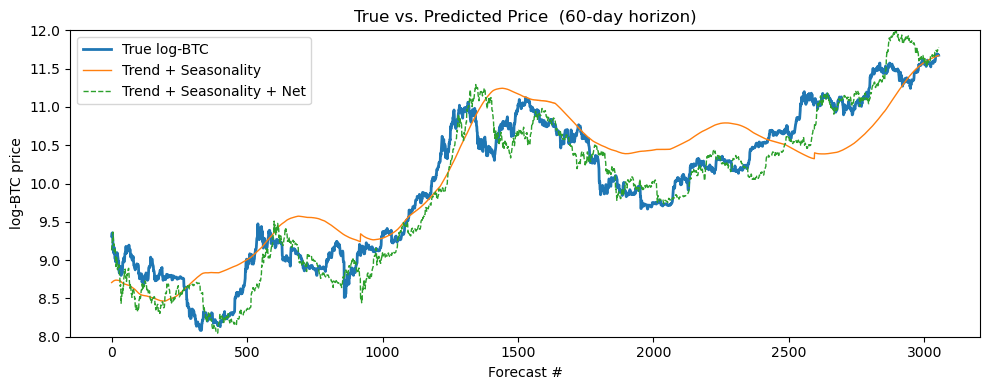

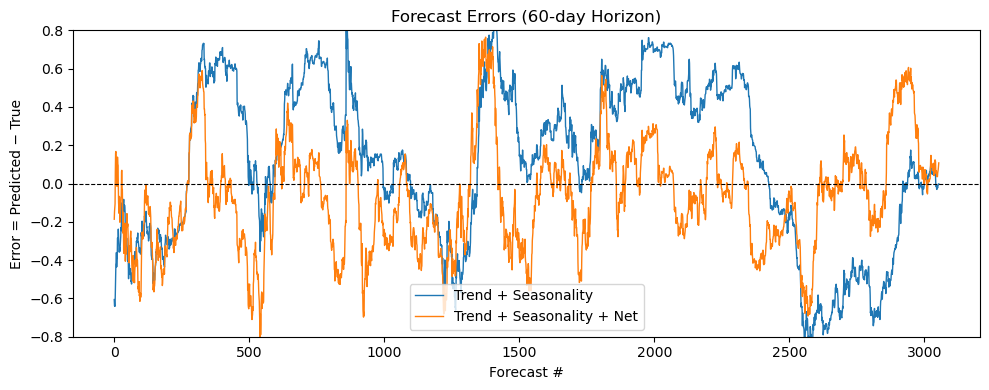

Classification report for Trend+Seasonality+Net:
              precision    recall  f1-score   support

        Down       0.57      0.69      0.62      1387
          Up       0.69      0.57      0.62      1667

    accuracy                           0.62      3054
   macro avg       0.63      0.63      0.62      3054
weighted avg       0.63      0.62      0.62      3054



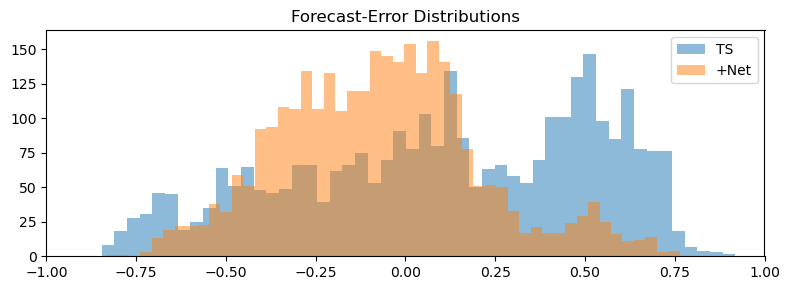

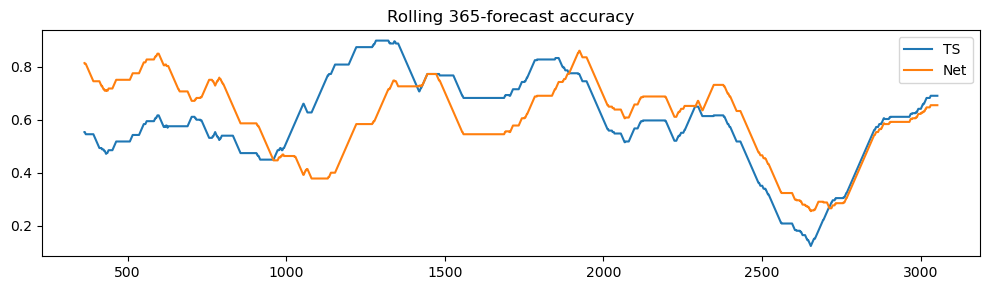

In [33]:
set_seed(101)

p=1
Days = 60
print(f"Predicting directional change {Days}-days in the future, use Trend + Seasonality + LSTM")

data = df2.copy()

ff=['M2','MSTR30','DXY']#['fed_rate', ,'log_MSTR','log_NVDIA']#,,

seq_len = 30                      # how many past days to feed into the LSTM
mlp_batch_size = 32
mlp_lr         = 1e-5
mlp_wd         = 1e-3   # L2 regularization
mlp_epochs     = 1
net  = ResidualLSTM(feat_dim=len(ff), hidden_size=25).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=mlp_lr, weight_decay=mlp_wd)
loss_fn   = nn.MSELoss()


dir_true      = []
dir_pred_ts = []
dir_pred_net  = []

y_t_list = []
y_td_true_list      = []
y_td_hat_ts_list  = []
y_td_hat_net_list   = []

min_train = 365 * 6
n = len(data)
start_time = time.time()

ii=0

for t in range(min_train, n - Days):
    ii+=1
    elapsed = time.time() - start_time
    avg_per_iter = elapsed / ii
    print(
        f"Processing time index {t} / {n-Days}  "
        f"(avg {avg_per_iter:.3f} s/iter)",
        end="\r"
    )

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[ts_features]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Trend+Seasonality log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][ts_features]
    X_td  = data.iloc[[t+Days]][ts_features]
    y_t_hat_ts  = lr.predict(X_t)[0]
    y_td_hat_ts = lr.predict(X_td)[0]

    # 3) Train net on residuals, 
    resid = y_train - lr.predict(X_train)
    resid_target = pd.Series(resid).shift(-Days)
    #    Drop the last 'Days' rows (they have NaN targets)
    if t == min_train:
        X_win = train[ff].iloc[: -Days].values            # shape (N, f)
        R_win = resid.iloc[: -Days].values                # shape (N,)
        y_win = resid_target.iloc[: -Days].values         # shape (N,)
    else:
        X_win = train[ff].iloc[-Days-80 : -Days].values    # shape (3D, f)
        R_win = resid.iloc[-Days-80 : -Days].values        # shape (3D,)
        y_win = resid_target.iloc[-Days-80 : -Days].values # shape (3D,)

    # build sliding windows of length `seq_len`
    T = X_win.shape[0]
    seq_feats, seq_resids, targets = [], [], []
    for i in range(T - seq_len + 1):
        seq_feats.append(  X_win[i : i+seq_len] )            # (seq_len, f)
        seq_resids.append( R_win[i : i+seq_len].reshape(-1,1) )  # (seq_len, 1)
        targets.append( y_win[i + seq_len - 1] )

    X_seq   = torch.tensor(np.stack(seq_feats),  dtype=torch.float32, device=device)  # (B, seq_len, f)
    R_seq   = torch.tensor(np.stack(seq_resids), dtype=torch.float32, device=device)  # (B, seq_len, 1)
    y_seq   = torch.tensor(targets,              dtype=torch.float32, device=device)  # (B,)
    
    loader = DataLoader(
        TensorDataset(X_seq, R_seq, y_seq),
        batch_size=mlp_batch_size,
        shuffle=True
    )  
    
    net.train()
    for _ in range(mlp_epochs):
        for xb_f, xb_r, yb in loader:
            optimizer.zero_grad()
            preds = net(xb_f, xb_r)
            loss  = loss_fn(preds.squeeze(-1), yb)
            loss.backward()
            optimizer.step()
    feat_window  = data[ff].iloc[t-seq_len+1 : t+1].values    # (seq_len, feat_dim)
    resid_window = np.array(resid.iloc[t-seq_len+1 : t+1]).reshape(seq_len, 1)
    x_feat_eval  = torch.tensor(feat_window[np.newaxis, ...], dtype=torch.float32, device=device)   # (1, seq_len, feat_dim)
    x_resid_eval = torch.tensor(resid_window[np.newaxis, ...], dtype=torch.float32, device=device) # (1, seq_len, 1)
    net.eval()
    with torch.no_grad():
        resid_pred = net(x_feat_eval, x_resid_eval).item()

    y_td_hat_net = y_td_hat_ts + resid_pred

    
    # 6) Record
    y_t=data.iloc[t]["log_BTC"]
    y_td=data.iloc[t+Days]["log_BTC"]

    dir_true.append(1 if y_td  > y_t else 0)
    dir_pred_ts.append(1 if y_td_hat_ts  > y_t_hat_ts  else 0)
    dir_pred_net.append( 1 if y_td_hat_net > y_t else 0)

    # --- store for later plotting ---
    y_t_list.append(y_t)
    y_td_true_list.append(y_td)
    y_td_hat_ts_list.append(y_td_hat_ts)
    y_td_hat_net_list.append(y_td_hat_net)

always1_acc = np.mean(dir_true)
always0_acc = 1 - always1_acc
yt = np.array(dir_true)
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
# print("Baselines:")
# print(f"  Always predict UP (1):        {always1_acc:.3%}")
# print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
# print(f"  Predict same as past:    {lag_acc:.3%}")
# print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

baselines = [always1_acc, always0_acc, lag_acc, opp_lag_acc]
p0 = max(baselines)
print(f"Best baseline accuracy is: {p0:.3%}")

N = len(dir_true)

models = {
    "Trend+Seasonality":           dir_pred_ts,
    "Trend+Seasonality + Net":     dir_pred_net
}

# 4) Compute z and approximate p-value
for name, preds in models.items():
    # count corrects
    preds = np.array(preds)
    true  = np.array(dir_true)
    k     = np.sum(preds == true)
    acc   = k / N
    cm= confusion_matrix(true, preds)

    # Normal approx
    mu    = N * p0
    sigma = np.sqrt(N * p0 * (1 - p0))
    z     = (k - mu) / sigma
    pval  = norm.sf(z)   # 1 - Phi(z)

    print(f"\n{name}:")
    print(f"  Observed accuracy = {acc:.3%}  ({k}/{N})")
    print(f"  z-score = {z:.3f}")
    print(f"  Approx. one-sided p-value = {pval:.5f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)

x = np.arange(len(y_td_true_list))

plt.figure(figsize=(10,4))
plt.plot(x, y_td_true_list,      label="True log-BTC",       linewidth=2)
plt.plot(x, y_td_hat_ts_list,  label="Trend + Seasonality",       linewidth=1)
plt.plot(x, y_td_hat_net_list,   label=f"Trend + Seasonality + Net", linewidth=1, linestyle="--")
plt.ylim(8, 12)
plt.xlabel("Forecast #")
plt.ylabel("log-BTC price")
plt.title(f"True vs. Predicted Price  ({Days}-day horizon)")
plt.legend()
plt.tight_layout()
plt.show()

# build the x-axis
x = np.arange(len(y_td_true_list))

# compute the three error series
errors_ts = np.array(y_td_hat_ts_list)  - np.array(y_td_true_list)
errors_net  = np.array(y_td_hat_net_list) - np.array(y_td_true_list)

plt.figure(figsize=(10,4))
plt.plot(x, errors_ts, label="Trend + Seasonality", linewidth=1)
plt.plot(x, errors_net,  label="Trend + Seasonality + Net", linewidth=1)

plt.ylim(-0.8, 0.8)
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)

plt.xlabel("Forecast #")
plt.ylabel("Error = Predicted − True")
plt.title(f"Forecast Errors ({Days}-day Horizon)")
plt.legend()
plt.tight_layout()
plt.show()

print("Classification report for Trend+Seasonality+Net:")
print(classification_report(dir_true, dir_pred_net, target_names=["Down","Up"]))

plt.figure(figsize=(8,3))
plt.hist(errors_ts, bins=50, alpha=0.5, label="TS")
plt.hist(errors_net,  bins=50, alpha=0.5, label="+Net")
plt.xlim(-1,1)
plt.legend()
plt.title("Forecast‐Error Distributions")
plt.tight_layout()
plt.show()

df_acc = pd.DataFrame({
    "TS": np.array(dir_pred_ts)==np.array(dir_true),
    "Net": np.array(dir_pred_net)==np.array(dir_true),
})
rolling = df_acc.rolling(365).mean()

plt.figure(figsize=(10,3))
for col in rolling.columns:
    plt.plot(rolling[col], label=col)
plt.legend()
plt.title("Rolling 365-forecast accuracy")
plt.tight_layout()
plt.show()
